<a href="https://colab.research.google.com/github/tbbcoach/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_ProjectNotebook_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders
    !pip install pdpbox
    !pip install shap

In [2]:
import pandas as pd
import numpy as np

from google.colab import files
upload =files.upload()


In [3]:
df_avocado = pd.read_csv('Augmented_avocado.csv')
df_avocado = df_avocado.drop(columns=['Unnamed: 0', 'year'])
df_avocado.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region
0,4/23/2017,1.324522,363844.11950,2086.305830,15297.247530,-513.654410,7256.068788,11363.872180,4579.307742,-1.727795,organic,Roanoke
1,3/29/2015,1.297376,412844.36890,29015.676120,88103.386590,2253.702012,49380.191010,29907.237220,4365.884161,54.793735,conventional,SanFrancisco
2,2/18/2018,1.469304,75577.23102,25218.753760,19653.059330,-748.277093,31900.310560,12429.538810,-167.238374,-84.541301,organic,Louisville
3,11/15/2015,1.681869,71767.40793,4466.005801,-8540.909251,-1087.310466,16692.401790,-5718.985732,25867.196990,-33.232127,organic,Albany
4,6/21/2015,1.334113,77935.77408,866.915215,8097.743815,1260.251319,-6184.326714,63516.027520,2879.525730,-20.586030,organic,SanFrancisco


In [4]:
#add 'cheap' column.  Based cutoff on mean AveragePrice

cutoff = 1.33
df_avocado['cheap'] = df_avocado.AveragePrice.apply(lambda x: 0 if x <= cutoff else 1)
df_avocado.type.astype(str)
df_avocado['type'] = df_avocado['type'].apply(lambda x: 1 if x == 'conventional' else 0)
df_avocado.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,cheap
0,4/23/2017,1.324522,363844.11950,2086.305830,15297.247530,-513.654410,7256.068788,11363.872180,4579.307742,-1.727795,0,Roanoke,0
1,3/29/2015,1.297376,412844.36890,29015.676120,88103.386590,2253.702012,49380.191010,29907.237220,4365.884161,54.793735,1,SanFrancisco,0
2,2/18/2018,1.469304,75577.23102,25218.753760,19653.059330,-748.277093,31900.310560,12429.538810,-167.238374,-84.541301,0,Louisville,1
3,11/15/2015,1.681869,71767.40793,4466.005801,-8540.909251,-1087.310466,16692.401790,-5718.985732,25867.196990,-33.232127,0,Albany,1
4,6/21/2015,1.334113,77935.77408,866.915215,8097.743815,1260.251319,-6184.326714,63516.027520,2879.525730,-20.586030,0,SanFrancisco,1


In [5]:
df_avocado.sort_values(by='Date')
df_avocado['Date'] = pd.to_datetime(df_avocado['Date'])
df_avocado.set_index('Date', inplace=True)

df_avocado.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,cheap
Date,,,,,,,,,,,,
2017-04-23,1.324522,363844.11950,2086.305830,15297.247530,-513.654410,7256.068788,11363.872180,4579.307742,-1.727795,0,Roanoke,0
2015-03-29,1.297376,412844.36890,29015.676120,88103.386590,2253.702012,49380.191010,29907.237220,4365.884161,54.793735,1,SanFrancisco,0
2018-02-18,1.469304,75577.23102,25218.753760,19653.059330,-748.277093,31900.310560,12429.538810,-167.238374,-84.541301,0,Louisville,1
2015-11-15,1.681869,71767.40793,4466.005801,-8540.909251,-1087.310466,16692.401790,-5718.985732,25867.196990,-33.232127,0,Albany,1
2015-06-21,1.334113,77935.77408,866.915215,8097.743815,1260.251319,-6184.326714,63516.027520,2879.525730,-20.586030,0,SanFrancisco,1


In [6]:
df_avocado.region.dtype

dtype('O')

In [7]:
df_avocado.region.value_counts(), df_avocado.cheap.value_counts()

(Indianapolis           26272
 California             26030
 GrandRapids            25987
 Detroit                24831
 SouthCarolina          24747
 Southeast              23817
 Seattle                23576
 Northeast              22760
 HarrisburgScranton     21887
 NewOrleansMobile       21635
 Pittsburgh             21348
 Nashville              20746
 Tampa                  20592
 PhoenixTucson          19963
 Portland               19680
 CincinnatiDayton       19419
 Atlanta                19413
 SanFrancisco           19297
 Jacksonville           19225
 SanDiego               18910
 LosAngeles             18891
 Chicago                18674
 Denver                 18419
 Spokane                18409
 DallasFtWorth          18185
 GreatLakes             18139
 Louisville             17776
 BuffaloRochester       17690
 MiamiFtLauderdale      17604
 RaleighGreensboro      17546
 Philadelphia           17447
 Boise                  17208
 Columbus               17164
 Albany   

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

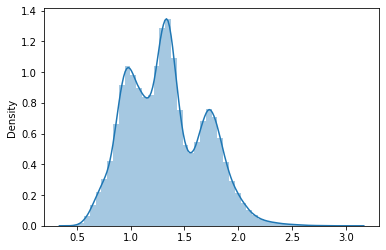

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot( x=df_avocado['AveragePrice'])

In [9]:
#Establish target

target = 'AveragePrice'
X = df_avocado.drop(columns=[target])
y = df_avocado[target]

X_train = X
y_train = y

X_train.shape, y_train.shape, X.shape, y.shape

((1000000, 11), (1000000,), (1000000, 11), (1000000,))

In [10]:
#Establish baseline

from sklearn.metrics import mean_absolute_error


majority_class = y_train.mean()
y_pred = [majority_class] * len(y_train)


baseline_mae = mean_absolute_error(y_train, y_pred)
print(y_train.value_counts())
print('Baseline MAE:', baseline_mae)
print('Average Price', y_train.mean())

1.672307    3
1.152550    3
1.212137    3
1.061407    3
1.356164    3
           ..
1.268624    1
2.077536    1
1.141190    1
0.885057    1
1.267470    1
Name: AveragePrice, Length: 997182, dtype: int64
Baseline MAE: 0.2885319320715948
Average Price 1.3270456864595341


In [11]:
df_avocado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2017-04-23 to 2018-02-18
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   AveragePrice  1000000 non-null  float64
 1   Total Volume  1000000 non-null  float64
 2   4046          1000000 non-null  float64
 3   4225          1000000 non-null  float64
 4   4770          1000000 non-null  float64
 5   Total Bags    1000000 non-null  float64
 6   Small Bags    1000000 non-null  float64
 7   Large Bags    1000000 non-null  float64
 8   XLarge Bags   1000000 non-null  float64
 9   type          1000000 non-null  int64  
 10  region        1000000 non-null  object 
 11  cheap         1000000 non-null  int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 99.2+ MB


In [12]:
df_avocado.region.value_counts()

Indianapolis           26272
California             26030
GrandRapids            25987
Detroit                24831
SouthCarolina          24747
Southeast              23817
Seattle                23576
Northeast              22760
HarrisburgScranton     21887
NewOrleansMobile       21635
Pittsburgh             21348
Nashville              20746
Tampa                  20592
PhoenixTucson          19963
Portland               19680
CincinnatiDayton       19419
Atlanta                19413
SanFrancisco           19297
Jacksonville           19225
SanDiego               18910
LosAngeles             18891
Chicago                18674
Denver                 18419
Spokane                18409
DallasFtWorth          18185
GreatLakes             18139
Louisville             17776
BuffaloRochester       17690
MiamiFtLauderdale      17604
RaleighGreensboro      17546
Philadelphia           17447
Boise                  17208
Columbus               17164
Albany                 17159
West          

In [13]:
df_avocado.type.head()

df_avocado["type"].astype(int)

Date
2017-04-23    0
2015-03-29    1
2018-02-18    0
2015-11-15    0
2015-06-21    0
             ..
2017-08-13    1
2016-07-10    0
2017-10-15    0
2017-04-30    0
2018-02-18    0
Name: type, Length: 1000000, dtype: int64

In [14]:
#build quick model

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer

model_cheap_lr = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

model_cheap_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': Roanoke                 1
SanFrancisco            2
Louisville              3
Albany                  4
GrandRapids             5
HartfordSpringfield     6
Nashville               7
Jacksonville            8
Detroit                 9
Orlando                10
MiamiFtLauderdale      11
Philadelphia           12
Mids...
dtype: int64}],
                                return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               ver

In [15]:
#add coefficients and look at DT and RF  models

In [16]:
training_acc = model_cheap_lr.score(X_train, y_train)

print('Training Accuracy', training_acc)

Training Accuracy 0.7038090880015244


In [17]:
coefficients = model_cheap_lr.named_steps['linearregression'].coef_
features = df_avocado.columns.drop('AveragePrice')
pd.Series(coefficients, features)

Total Volume   -0.005349
4046           -0.005051
4225           -0.004959
4770           -0.006881
Total Bags     -0.005478
Small Bags     -0.004317
Large Bags     -0.006048
XLarge Bags    -0.007999
type           -0.068507
region         -0.004601
cheap           0.244478
dtype: float64

In [18]:
#gradient boosting model
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
model_cheap_lr_gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)

)

model_cheap_lr_gb.fit(X_train, y_train)
y_pred = model_cheap_lr_gb.predict(X_train)
print('Gradient Boosting R^2', r2_score(y_train, y_pred))

Gradient Boosting R^2 0.7242598968974111
